In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.sparse import spdiags, csr_matrix
from scipy.sparse.linalg import gmres, bicgstab
import scipy.linalg as la
import time

m = 64
n = m * m
dx = (10 - (-10)) / (m)

e0 = np.zeros((n, 1))
e1 = np.ones((n, 1)) 

e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m + 1):
    e2[m * j - 1] = 0
    e4[m * j - 1] = 1

e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n - 1]
e3[0] = e2[n - 1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n - 1]
e5[0] = e4[n - 1]

e6 = np.copy(e5)
diagonals_A = [
    e1.flatten(), e1.flatten(), e5.flatten(),
    e2.flatten(), -4 * e1.flatten(), e3.flatten(),
    e4.flatten(), e1.flatten(), e1.flatten()
]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]
A = spdiags(diagonals_A, offsets_A, n, n).toarray() / dx**2

diagonals_B = [
    -1 * e1.flatten(), 1 * e1.flatten(), 1 * e1.flatten(),
    -1 * e1.flatten()
]
offsets_B = [-m, m, -n + m, n - m]
B = spdiags(diagonals_B, offsets_B, n, n).toarray() / (2*dx)

diagonals_C = [-1 * e2.flatten(), 1 * e3.flatten(), 1 * e5.flatten(), -1 * e4.flatten()]
offsets_C = [-1, 1, -m + 1, m - 1]
C = spdiags(diagonals_C, offsets_C, n, n).toarray() / (2*dx)

# Define parameters
tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial condition
Lx, Ly = 20, 20
x = np.linspace(-Lx/2, Lx/2, nx+1)  # Use nx points
y = np.linspace(-Ly/2, Ly/2, ny+1)  # Use ny points
x = x[:nx]
y = y[:ny]
X, Y = np.meshgrid(x, y)          # Create 2D grid
w = np.exp(-X**2 - (1/2)*Y**2).flatten()   # Compute the initial condition

times = {}

In [20]:
class GifCreator:
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter
    import numpy as np
    def __init__(self, num_sol, tspan, x, y):
        self.num_sol = num_sol.T.reshape(tspan.shape[0], 4096)
        self.tspan = tspan
        self.x, self.y = x, y
        self.fig, self.ax = plt.subplots()
        self.c = self.ax.pcolor(x, y, self.num_sol[0].reshape(64, 64), shading='auto', cmap='viridis',)
        self.fig.colorbar(self.c, ax=self.ax)
        self.time_text = self.ax.text(0.05, 0.95, '', transform=self.ax.transAxes, color='white', fontsize=12)

    def update(self, frame):
        self.c.set_array(self.num_sol[frame].reshape(64, 64).flatten())
        self.time_text.set_text(f'Time: {self.tspan[frame]:.2f}')
        return self.c, self.time_text

    def animate(self, name="", save=False, show=False):
        ani = self.FuncAnimation(self.fig, self.update, frames=len(self.num_sol), interval=100, blit=False)
        if save:
            ani.save(f'vortices_{name}.gif', writer='pillow', fps=10)
        plt.show()

        if show:
            for j in range(min(len(self.num_sol), tspan.shape[0])):
                
                plt.subplot(int(np.sqrt(tspan.shape[0]))+1, int(np.sqrt(tspan.shape[0]))+1, j + 1)
                plt.pcolor(self.x, self.y, self.num_sol[j].reshape(64, 64), shading='auto', cmap='viridis')
                plt.colorbar()
    
            plt.tight_layout()
            plt.show()


In [21]:

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2
tspan = np.arange(0, 4.5, 0.5)
# Define the ODE system
def spc_rhs(t, wt, nx, ny, N, KX, KY, K, nu):
    wtf = fft2(wt.reshape(64,64))
    psif = -wtf / K
    psi = np.real(ifft2(psif)).flatten()
    w = wt.flatten()
    rhs = (nu*A.dot(w) - ((B.dot(psi)) * C.dot(w)- ((C.dot(psi))*(B.dot(w)))))
    return rhs.flatten()

solution = solve_ivp(
    spc_rhs, 
    t_span=(tspan[0], tspan[-1]), 
    y0=w, 
    t_eval=tspan, 
    args=(nx, ny, N, KX, KY, K, nu),
    method='RK45'  # Default method, but can choose others like 'RK23', 'BDF', etc.
)

spiral = solution.y


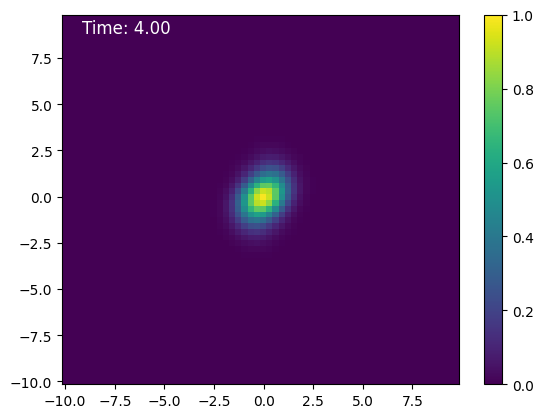

In [22]:
gif = GifCreator(spiral, tspan, x, y)
gif.animate("Spiral", True)